In [1]:
import pickle
import sys
sys.path.append('..')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from brainbox import physiology as phys

First run the code below to load up all the relevant files and instantiate two dummy models (a full model trained on naturalistic video clips and the same model where video clips were shuffled during training) which will be used by the RSA class. 

In [2]:
# Dummy model class which loads the outputs from a pre-trained model
class DummyModel:
    def __init__ (self, static, moving):
        self.static_stimuli, self.static_responses = static
        self.moving_stimuli, self.moving_responses = moving
        
    def __call__ (self, x):
        if np.array_equal(x, self.static_stimuli):
            return self.static_responses
        elif np.array_equal(x, self.moving_stimuli):
            return self.moving_responses
        else:
            raise Exception('No stored responses for this input.')

# Load stimuli, precomputed model responses and neural responses
moving_stimuli            = np.load('./misc/rsa/mov_stimuli.npy')
static_stimuli            = np.load('./misc/rsa/stat_stimuli.npy') 
shuffledtp_mov_responses  = np.load('./misc/rsa/shuffledtp_mov_responses.npy')
shuffledtp_stat_responses = np.load('./misc/rsa/shuffledtp_stat_responses.npy')
tp_mov_responses          = np.load('./misc/rsa/tp_mov_responses.npy')
tp_stat_responses         = np.load('./misc/rsa/tp_stat_responses.npy')
v1_responses              = np.load('./misc/rsa/v1_responses.npy')

# Instantiate our 'models'
tp_model       = DummyModel(
    [static_stimuli, tp_stat_responses],
    [moving_stimuli, tp_mov_responses]
)
shuffled_model = DummyModel(
    [static_stimuli, shuffledtp_stat_responses],
    [moving_stimuli, shuffledtp_mov_responses]
)

# Instantiate RSA objects with each model, stimuli and neural responses
tp_rsa       = phys.rsa.RSA(tp_model,       static_stimuli, moving_stimuli, v1_responses)
shuffled_rsa = phys.rsa.RSA(shuffled_model, static_stimuli, moving_stimuli, v1_responses)

Now let's get the similarity score for each model compared with mouse V1. Because we've already passed in the neural data during class instantiation, we don't have to pass anything in again.

In [3]:
tp_similarity       = tp_rsa.compare_model()
shuffled_similarity = shuffled_rsa.compare_model()

print('TP similarity =', tp_similarity)
print('Shuffled similarity =', shuffled_similarity)

TP similarity = 0.1687772572365833
Shuffled similarity = -0.008599415770587805


Although it looks like the full model is doing better than the shuffled model, these scores aren't normalized to the noise ceilling of each mouse. To get a better absolute measure, let's run the code again but this time correcting for noise in the neural data.

Depending on how many iterations you choose, this could take some time. For speed, we'll choose 10 but you'd probably want a higher number of iterations for a better estimate. After running, the noise ceiling will be cached for future use.

In [4]:
tp_similarity       = tp_rsa.compare_model(noise_corrected=10)
shuffled_similarity = shuffled_rsa.compare_model(noise_corrected=10)

print('TP similarity =', tp_similarity)
print('Shuffled similarity =', shuffled_similarity)

TP similarity = 0.5416259618354545
Shuffled similarity = -0.030490303795991207


Finally, we can compare all models against each other by passing in all the models and responses we want to compare.

Correlation matrix between models:
[[ 1.          0.16877726  0.11095953]
 [ 0.16877726  1.         -0.00859942]
 [ 0.11095953 -0.00859942  1.        ]]


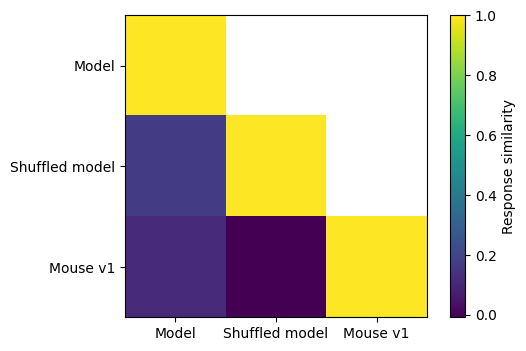

In [5]:
correlation_matrix = tp_rsa.compare_model([tp_rsa.neural_responses, shuffled_rsa])

print('Correlation matrix between models:')
print(correlation_matrix)

phys.rsa.RSA.plot_correlation_matrix(correlation_matrix, ['Model', 'Shuffled model', 'Mouse v1'])